# Model Building

---

1. Import packages
2. Load data
3. Modelling

---

## 1.) Import packages

In [170]:
import warnings
warnings.filterwarnings("ignore")

In [171]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import pickle

import nltk
from nltk.stem.porter import PorterStemmer
nltk.download('stopwords')
from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('english'))

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from wordcloud import WordCloud
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
import re

# Shows plots in jupyter notebook
%matplotlib inline

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\SANTHEEPPA\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


---
## 2.) Load the data

In [172]:
df = pd.read_csv('../data/feature_engineered_data/amazon_alexa.tsv', delimiter='\t', quoting=3)

#### Show Top 5 Records

In [173]:
df.head()

,rating,date,variation,verified_reviews,feedback,length
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1,13
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1,9
2,4,31-Jul-18,Walnut Finish,"""""""Sometimes while playing a game, you can ans...",1,197
3,5,31-Jul-18,Charcoal Fabric,"""""""I have had a lot of fun with this thing. My...",1,174
4,5,31-Jul-18,Charcoal Fabric,Music,1,5


--------------------------------------------------
# 3. Modelling
--------------------------------------------------

### To build the corpus from the 'verified_reviews' we perform the following - <br>
1. Replace any non alphabet characters with a space
2. Covert to lower case and split into words
3. Iterate over the individual words and if it is not a stopword then add the stemmed form of the word to the corpus

---

- For those who don't know, **Corpus** refers to a collection of textual data that you will use for analysis.

In [174]:
print(df.columns)

Index(['rating', 'date', 'variation', 'verified_reviews', 'feedback',
       'length'],
      dtype='object')


In [175]:
corpus = []
stemmer = PorterStemmer()
for i in range(0, df.shape[0]):
  review = re.sub('[^a-zA-Z]', ' ', df.iloc[i]['verified_reviews'])
  review = review.lower().split()
  review = [stemmer.stem(word) for word in review if not word in STOPWORDS]
  review = ' '.join(review)
  corpus.append(review)

Using Count Vectorizer to create bag of words

In [176]:
cv = CountVectorizer(max_features = 2500)

#Storing independent and dependent variables in X and y
X = cv.fit_transform(corpus).toarray()
y = df['feedback'].values

### Saving the Count Vectorizer

In [177]:
save_location = '../Models/countVectorizer.pkl'

# Create the directory if it doesn't exist
os.makedirs(os.path.dirname(save_location), exist_ok=True)

# Save the Count Vectorizer
with open(save_location, 'wb') as file:
    pickle.dump(cv, file)

### Checking the shape of X and y

In [178]:
print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")

X shape: (3149, 2500)
y shape: (3149,)


Splitting data into train and test set with 30% data with testing.

In [179]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 15)

print(f"X train: {X_train.shape}")
print(f"y train: {y_train.shape}")
print(f"X test: {X_test.shape}")
print(f"y test: {y_test.shape}")

X train: (2204, 2500)
y train: (2204,)
X test: (945, 2500)
y test: (945,)


In [180]:
print(f"X train max value: {X_train.max()}")
print(f"X test max value: {X_test.max()}")

X train max value: 12
X test max value: 10


### We'll scale X_train and X_test so that all values are between 0 and 1.

In [181]:
scaler = MinMaxScaler()

X_train_scl = scaler.fit_transform(X_train)
X_test_scl = scaler.transform(X_test)

In [182]:
#Saving the scaler model
pickle.dump(scaler, open('../Models/scaler.pkl', 'wb'))

### RandomForestClassifier Model

In [183]:
#Fitting scaled X_train and y_train on Random Forest Classifier
model_rf = RandomForestClassifier()
model_rf.fit(X_train_scl, y_train)

RandomForestClassifier()

In [184]:
#Accuracy of the model on training and testing data
 
print("Training Accuracy :", model_rf.score(X_train_scl, y_train))
print("Testing Accuracy :", model_rf.score(X_test_scl, y_test))

Training Accuracy : 0.9945553539019963
Testing Accuracy : 0.944973544973545


In [185]:
#Predicting on the test set
y_preds_rf = model_rf.predict(X_test_scl)

In [186]:
#Confusion Matrix
cm = confusion_matrix(y_test, y_preds_rf)

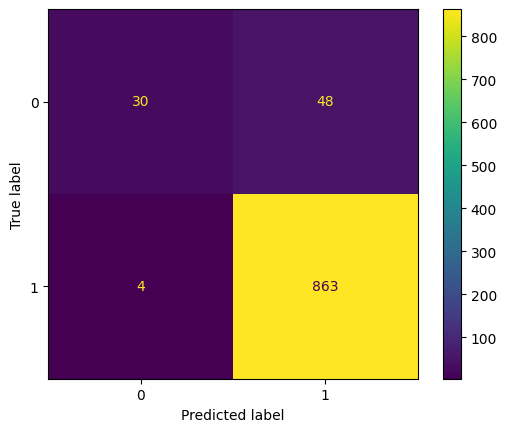

In [187]:
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model_rf.classes_)
cm_display.plot()
plt.show()

In [188]:
#Saving the XGBoost classifier
pickle.dump(model_rf, open('../Models/model_rf.pkl', 'wb'))

### K fold cross-validation

In [189]:
accuracies = cross_val_score(estimator = model_rf, X = X_train_scl, y = y_train, cv = 10)

print("Accuracy :", accuracies.mean())
print("Standard Variance :", accuracies.std())

Accuracy : 0.9305861785273549
Standard Variance : 0.008086946672199162


### Applying grid search to get the optimal parameters on random forest

In [190]:
params = {
    'bootstrap': [True],
    'max_depth': [80, 100],
    'min_samples_split': [8, 12],
    'n_estimators': [100, 300]
}

In [191]:
cv_object = StratifiedKFold(n_splits = 2)

grid_search = GridSearchCV(estimator = model_rf, param_grid = params, cv = cv_object, verbose = 0, return_train_score = True)
grid_search.fit(X_train_scl, y_train.ravel())

GridSearchCV(cv=StratifiedKFold(n_splits=2, random_state=None, shuffle=False),
             estimator=RandomForestClassifier(),
             param_grid={'bootstrap': [True], 'max_depth': [80, 100],
                         'min_samples_split': [8, 12],
                         'n_estimators': [100, 300]},
             return_train_score=True)

In [192]:
#Getting the best parameters from the grid search

print("Best Parameter Combination : {}".format(grid_search.best_params_))

Best Parameter Combination : {'bootstrap': True, 'max_depth': 100, 'min_samples_split': 12, 'n_estimators': 100}


In [193]:
print("Cross validation mean accuracy on train set : {}".format(grid_search.cv_results_['mean_train_score'].mean()*100))
print("Cross validation mean accuracy on test set : {}".format(grid_search.cv_results_['mean_test_score'].mean()*100))
print("Accuracy score for test set :", accuracy_score(y_test, y_preds_rf))

Cross validation mean accuracy on train set : 96.79559891107078
Cross validation mean accuracy on test set : 92.19033575317604
Accuracy score for test set : 0.944973544973545


### XgBoost Model

In [194]:
model_xgb = XGBClassifier()
model_xgb.fit(X_train_scl, y_train)
print(model_xgb)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)


In [195]:
#Accuracy of the model on training and testing data
 
print("Training Accuracy :", model_xgb.score(X_train_scl, y_train))
print("Testing Accuracy :", model_xgb.score(X_test_scl, y_test))

Training Accuracy : 0.971415607985481
Testing Accuracy : 0.9417989417989417


In [196]:
y_preds_xgb = model_xgb.predict(X_test)

In [197]:
#Confusion Matrix
cm = confusion_matrix(y_test, y_preds_xgb)
print(cm)

[[ 31  47]
 [ 13 854]]


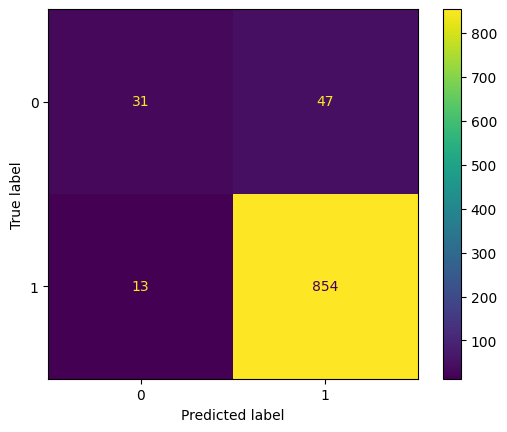

In [198]:
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model_xgb.classes_)
cm_display.plot()
plt.show()

In [199]:
#Saving the XGBoost classifier
pickle.dump(model_xgb, open('../Models/model_xgb.pkl', 'wb'))

### Decision Tree Classifier Model.

In [200]:
model_dt = DecisionTreeClassifier()
model_dt.fit(X_train_scl, y_train)

DecisionTreeClassifier()

In [201]:
#Accuracy of the model on training and testing data
 
print("Training Accuracy :", model_dt.score(X_train_scl, y_train))
print("Testing Accuracy :", model_dt.score(X_test_scl, y_test))

Training Accuracy : 0.9945553539019963
Testing Accuracy : 0.9248677248677248


In [202]:
y_preds_dt = model_dt.predict(X_test)

In [203]:
#Confusion Matrix
cm = confusion_matrix(y_test, y_preds_dt)
print(cm)

[[ 40  38]
 [ 65 802]]


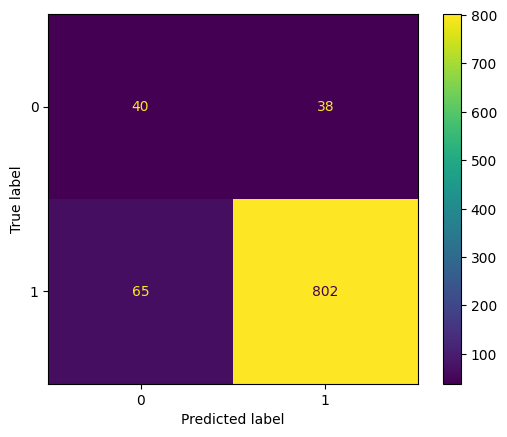

In [204]:
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model_dt.classes_)
cm_display.plot()
plt.show()